# Automatically find cuts

## Step 1: Map

#### Create a circuit and observables

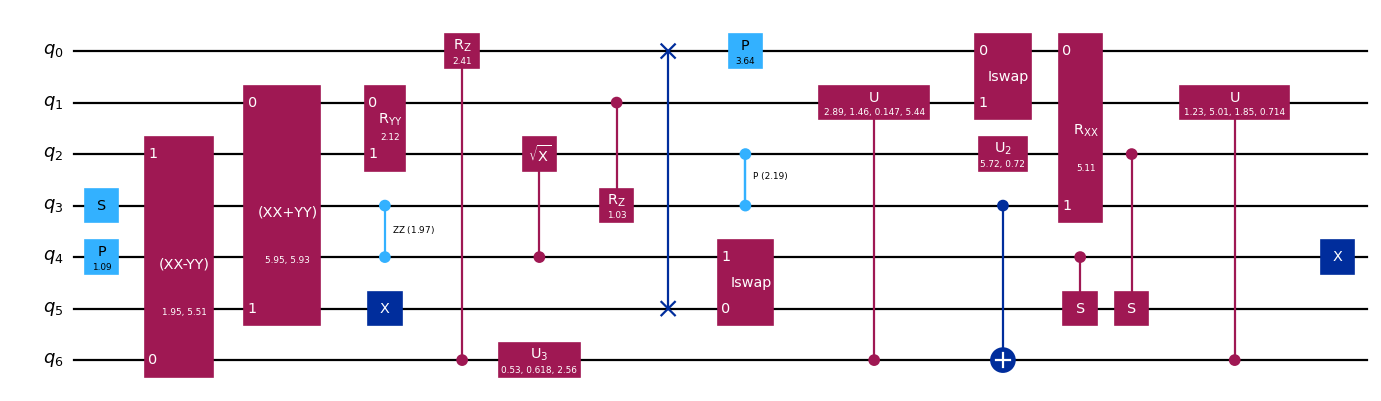

In [1]:
import numpy as np
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

circuit = random_circuit(7, 6, max_operands=2, seed=1242)
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])


circuit.draw("mpl", scale=0.8)

## Step 2: Optimize

#### Find cut locations, given a maximum of 4 qubits per subcircuit. This circuit can be separated in two by making a single wire cut and cutting one `CRZGate`

Found solution using 8 cuts with a sampling overhead of 59776343.19975524.
Lowest cost solution found: False.
Gate Cut at circuit instruction index 6
Gate Cut at circuit instruction index 8
Gate Cut at circuit instruction index 9
Wire Cut at circuit instruction index 10
Gate Cut at circuit instruction index 15
Gate Cut at circuit instruction index 18
Gate Cut at circuit instruction index 19
Gate Cut at circuit instruction index 21


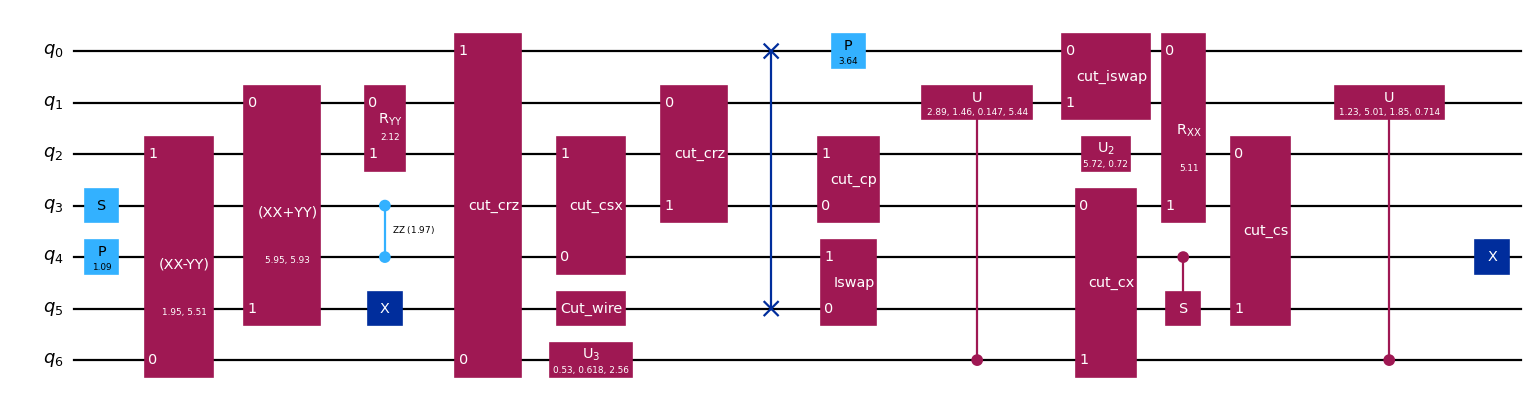

In [2]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=4)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

#### Add ancillas for wire cuts and expand the observables to account for ancilla qubits

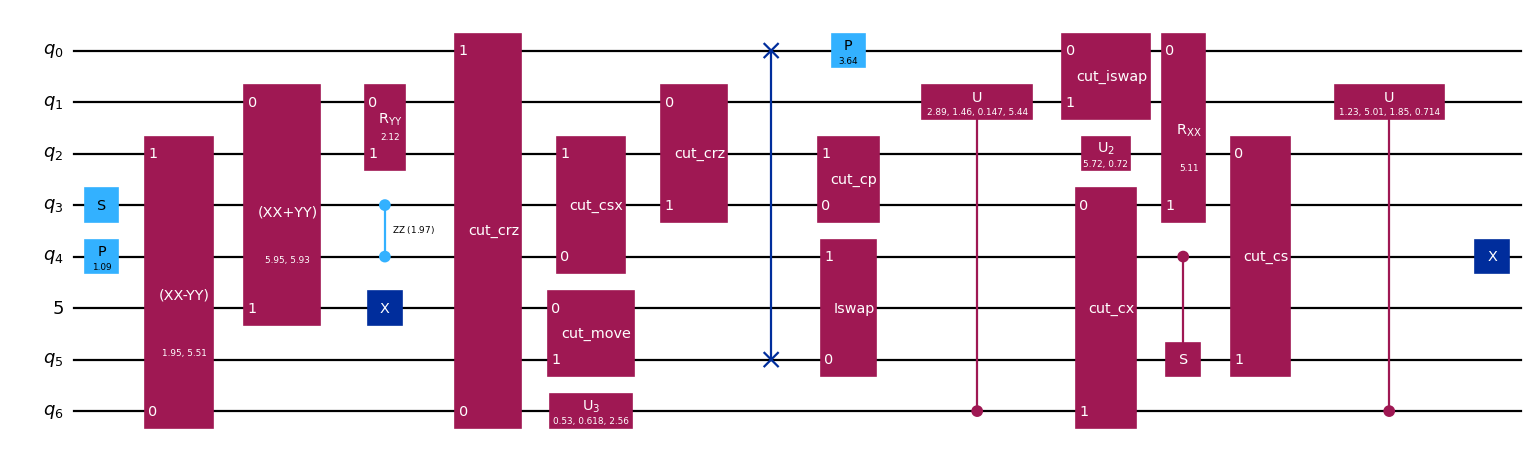

In [3]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

#### Partition the circuit and observables into subcircuits and subobservables. Calculate the sampling overhead incurred from cutting these gates and wires.

In [4]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

Sampling overhead: 59776343.19975523


In [5]:
subobservables

{0: PauliList(['IIII', 'IIZI', 'IIIZ']),
 1: PauliList(['ZIII', 'IIII', 'IIII'])}

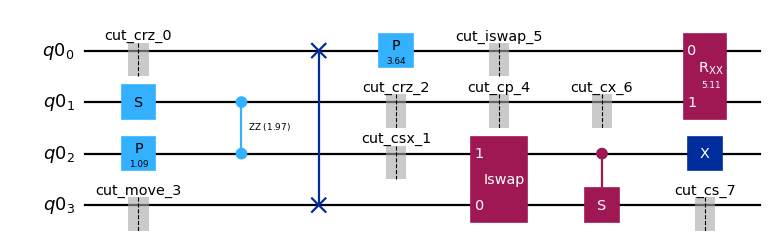

In [6]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

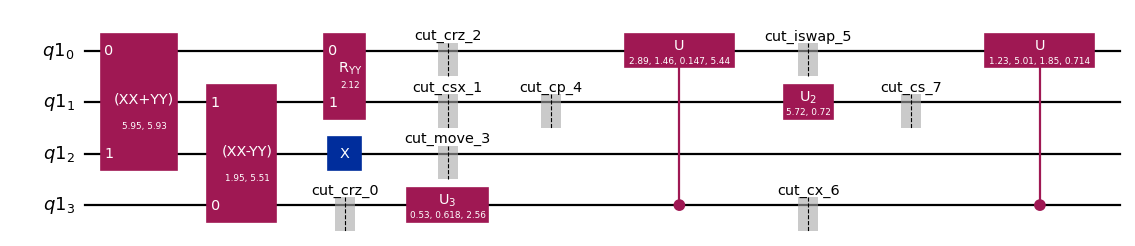

In [7]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

#### Generate the experiments to run on the backend.

In [8]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=1_000
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

2000 total subexperiments to run on backend.


Steps 3 and 4 of a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) can then be performed as in the preceding tutorials.